<a href="https://colab.research.google.com/github/bhuvighosh3/Final-Year-Project/blob/main/FYP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
vers = torch.__version__
print("Torch vers: ", vers)

# PyG installation
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

Torch vers:  2.5.1+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Corrected Fraud Detection Code with PyTorch Geometric

import torch
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import GATConv
from torch.nn import Linear
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Load Dataset
train_data = UPFD(root=".", name="gossipcop", feature="content", split="train")
test_data = UPFD(root=".", name="gossipcop", feature="content", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Extracting ./gossipcop/raw/data.zip
Processing...
Done!


Train Samples:  1092
Test Samples:  3826


In [ ]:
# Define GNN Model

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        # Graph Convolutions
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Readout
        self.lin_news = Linear(in_channels, hidden_channels)
        self.lin0 = Linear(hidden_channels, hidden_channels)
        self.lin1 = Linear(2 * hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # Graph Convolutions
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index).relu()

        # Pooling
        h = gmp(h, batch)

        # Readout
        h = self.lin0(h).relu()

        # Include raw word2vec embeddings of news
        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)
        news = x[root]
        news = self.lin_news(news).relu()

        out = self.lin1(torch.cat([h, news], dim=-1))
        return torch.sigmoid(out)


In [ ]:
# Instantiate Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(train_data.num_features, 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loss_fnc = torch.nn.BCELoss()

In [ ]:
# Data Loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
# Training Function
def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fnc(out.view(-1), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

In [ ]:
# Test Function
@torch.no_grad()
def test(epoch):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch).view(-1)  # Flatten output
        loss = loss_fnc(out, data.y.float())
        total_loss += float(loss) * data.num_graphs
        all_preds.append(out.cpu().numpy())  # Convert to NumPy
        all_labels.append(data.y.cpu().numpy())  # Convert to NumPy

    # Concatenate all batches into single arrays
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Calculate Metrics
    accuracy, f1 = metrics(all_preds, all_labels)

    return total_loss / len(test_loader.dataset), accuracy, f1

# Metrics Function
def metrics(preds, gts):
    preds = np.round(preds)  # No need for torch.tensor here
    acc = accuracy_score(gts, preds)
    f1 = f1_score(gts, preds)
    return acc, f1

In [ ]:
# Training Loop
for epoch in range(40):
    train_loss = train(epoch)
    test_loss, test_acc, test_f1 = test(epoch)
    print(f'Epoch: {epoch:02d} |  TrainLoss: {train_loss:.2f} | '
          f'TestLoss: {test_loss:.2f} | TestAcc: {test_acc:.2f} | TestF1: {test_f1:.2f}')

Epoch: 00 |  TrainLoss: 0.71 | TestLoss: 0.73 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 01 |  TrainLoss: 0.71 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.01
Epoch: 02 |  TrainLoss: 0.69 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 03 |  TrainLoss: 0.70 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 04 |  TrainLoss: 0.68 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 05 |  TrainLoss: 0.70 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 06 |  TrainLoss: 0.71 | TestLoss: 0.69 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 07 |  TrainLoss: 0.69 | TestLoss: 0.71 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 08 |  TrainLoss: 0.68 | TestLoss: 0.71 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 09 |  TrainLoss: 0.70 | TestLoss: 0.71 | TestAcc: 0.50 | TestF1: 0.67
Epoch: 10 |  TrainLoss: 0.69 | TestLoss: 0.68 | TestAcc: 0.50 | TestF1: 0.00
Epoch: 11 |  TrainLoss: 0.68 | TestLoss: 0.67 | TestAcc: 0.59 | TestF1: 0.31
Epoch: 12 |  TrainLoss: 0.68 | TestLoss: 0.67 | TestAcc: 0.50 | TestF1: 0.67

In [ ]:
# Prediction Example
for data in test_loader:
    data = data.to(device)
    pred = model(data.x, data.edge_index, data.batch)
    df = pd.DataFrame()
    df["pred_logit"] = pred.detach().cpu().numpy()[:, 0]  # Convert to NumPy
    df["pred"] = torch.round(pred).detach().cpu().numpy()[:, 0]  # Convert to NumPy
    df["true"] = data.y.cpu().numpy()  # Convert to NumPy
    print(df.head(10))
    break


   pred_logit  pred  true
0    0.932859   1.0     1
1    0.860987   1.0     1
2    0.700961   1.0     0
3    0.872024   1.0     1
4    0.396137   0.0     0
5    0.692383   1.0     0
6    0.626367   1.0     0
7    0.962157   1.0     1
8    0.403541   0.0     0
9    0.611144   1.0     0


Number of graphs: 1092
Number of features per node: 310
Number of classes: 2
First Graph: Data(x=[76, 310], edge_index=[2, 75], y=[1])


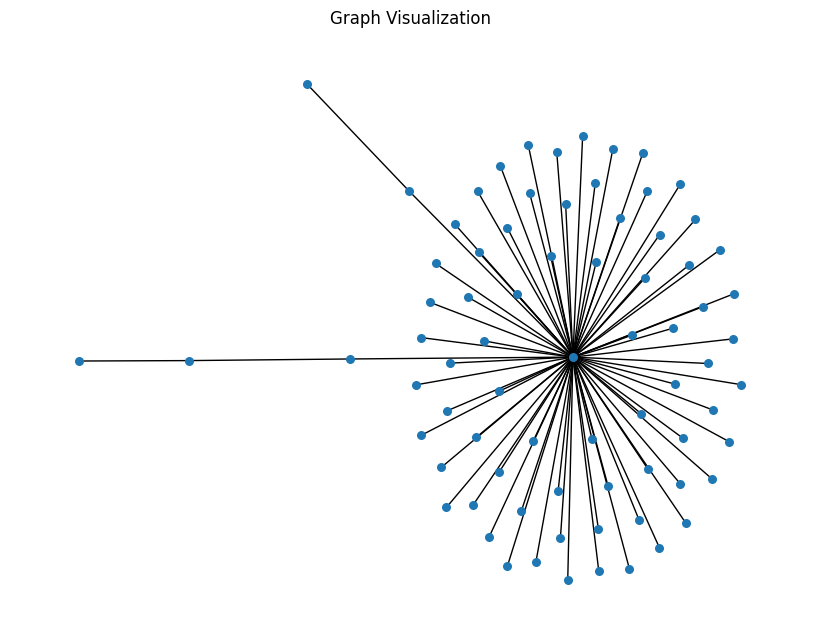

In [ ]:
# Inspect train_data information
print(f"Number of graphs: {len(train_data)}")
print(f"Number of features per node: {train_data.num_features}")
print(f"Number of classes: {train_data.num_classes}")
print(f"First Graph: {train_data[0]}")


import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

# Convert the first graph to a NetworkX graph
graph = to_networkx(train_data[0], to_undirected=True)

# Visualize the graph
plt.figure(figsize=(8, 6))
nx.draw(graph, node_size=30, with_labels=False)
plt.title("Graph Visualization")
plt.show()


In [ ]:
# Access node features of the first graph
first_graph = train_data[0]
print("Node features shape: ", first_graph.x.shape)
print("Node features: ", first_graph.x[:5])  # Display first 5 node features

# Access labels
print("Graph label (y): ", first_graph.y)


Node features shape:  torch.Size([76, 310])
Node features:  tensor([[0.5100, 0.5259, 0.5432,  ..., 0.6794, 0.1175, 0.1534],
        [0.4455, 0.5350, 0.5522,  ..., 0.0890, 0.1111, 0.1324],
        [0.4417, 0.5409, 0.5583,  ..., 0.4658, 0.1667, 0.1765],
        [0.4524, 0.5438, 0.5748,  ..., 0.8425, 0.1111, 0.1324],
        [0.4417, 0.5409, 0.5583,  ..., 0.4452, 0.2778, 0.3971]])
Graph label (y):  tensor([0])


### Misinformation spread

Top 5 Nodes by Degree Centrality: [(0, 0.3064516129032258), (28, 0.282258064516129), (26, 0.07258064516129031), (22, 0.04032258064516129), (38, 0.04032258064516129)]
Top 5 Nodes by Betweenness Centrality: [(28, 0.0034093889325990034), (83, 0.0006556517178075007), (26, 0.0005900865460267506), (65, 0.0003933910306845004), (115, 0.0003933910306845004)]
Top 5 Nodes by Eigenvector Centrality: [(118, 0.99973325934168), (102, 0.013329014517807153), (113, 0.013329014517807153), (117, 0.013329014517807153), (41, 0.00014179199342382765)]
Misinformation Propagators: [0]


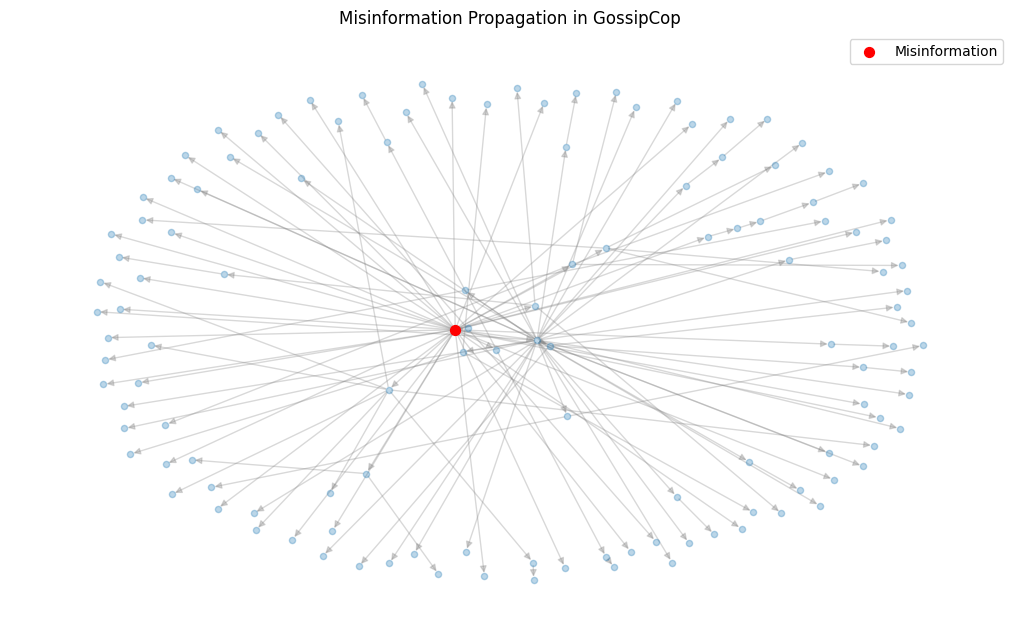

In [13]:
import torch
from torch_geometric.datasets import UPFD
import networkx as nx
import matplotlib.pyplot as plt

dataset = UPFD(root=".", name="gossipcop", feature="content", split="train")
data_sample = dataset[1]

G = nx.DiGraph()
edges = data_sample.edge_index.t().tolist()
G.add_edges_from(edges)

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 Nodes by Degree Centrality:", top_degree)
print("Top 5 Nodes by Betweenness Centrality:", top_betweenness)
print("Top 5 Nodes by Eigenvector Centrality:", top_eigenvector)

misinfo_nodes = (data_sample.y == 1).nonzero(as_tuple=True)[0].tolist()
print(f"Misinformation Propagators: {misinfo_nodes[:5]}")

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=20, edge_color="gray", alpha=0.3)
nx.draw_networkx_nodes(G, pos, nodelist=misinfo_nodes, node_color="red", node_size=50, label="Misinformation")
plt.title("Misinformation Propagation in GossipCop")
plt.legend()
plt.show()

Top 5 Nodes by Degree Centrality: [(0, 0.3064516129032258), (28, 0.282258064516129), (26, 0.07258064516129031), (22, 0.04032258064516129), (38, 0.04032258064516129)]
Top 5 Nodes by Betweenness Centrality: [(28, 0.0034093889325990034), (83, 0.0006556517178075007), (26, 0.0005900865460267506), (65, 0.0003933910306845004), (115, 0.0003933910306845004)]
Top 5 Nodes by Eigenvector Centrality: [(118, 0.99973325934168), (102, 0.013329014517807153), (113, 0.013329014517807153), (117, 0.013329014517807153), (41, 0.00014179199342382765)]
Misinformation Propagators: [0]
Communities Likely Spreading Misinformation: {0}


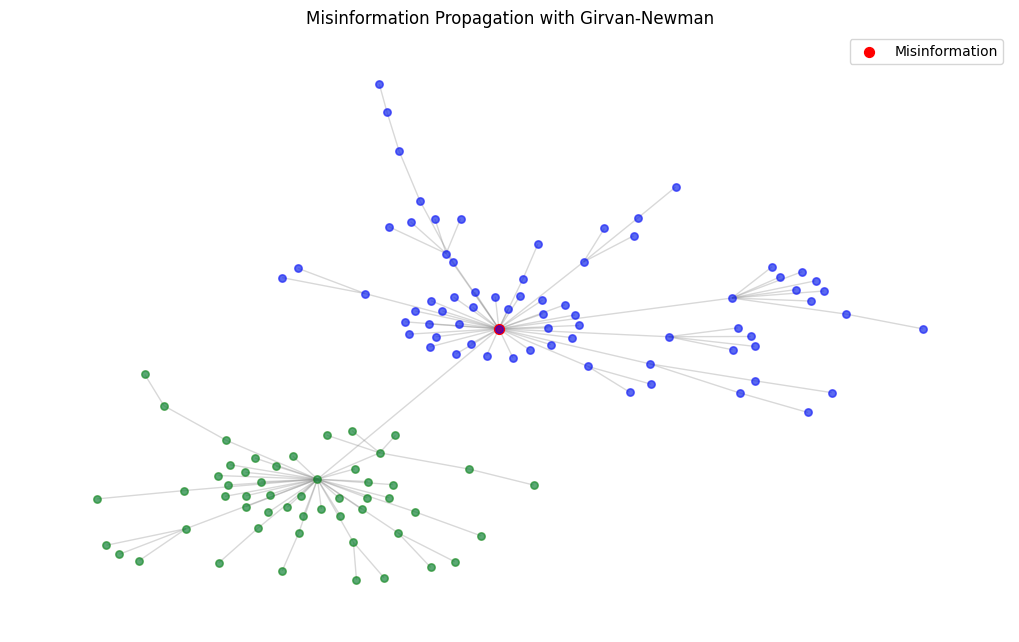

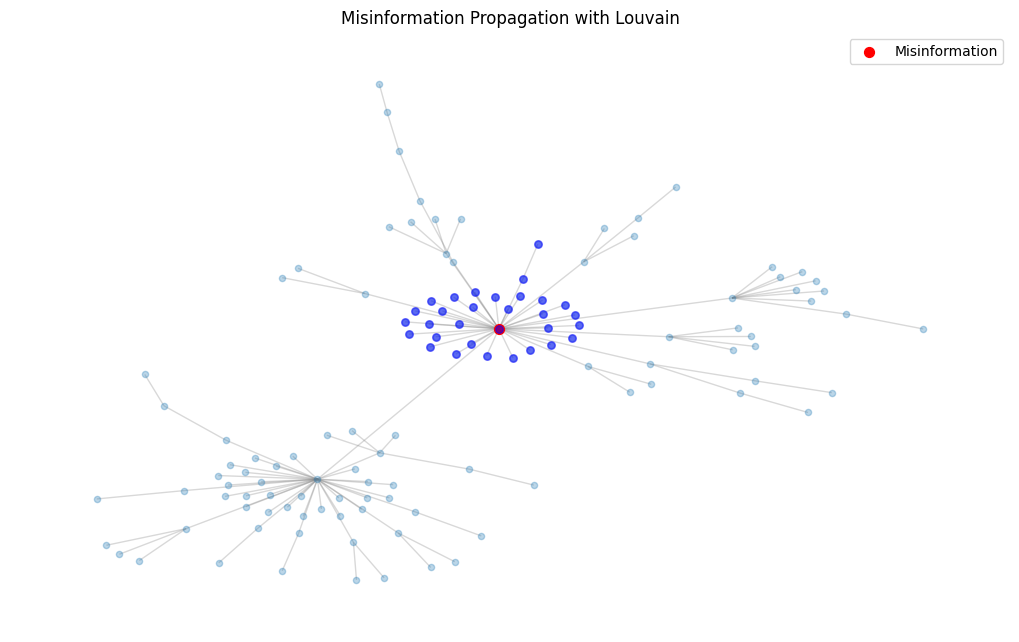

In [20]:
import torch
from torch_geometric.datasets import UPFD
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from networkx.algorithms.community import girvan_newman

dataset = UPFD(root=".", name="gossipcop", feature="content", split="train")
data_sample = dataset[1]

G = nx.DiGraph()
edges = data_sample.edge_index.t().tolist()
G.add_edges_from(edges)

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 Nodes by Degree Centrality:", top_degree)
print("Top 5 Nodes by Betweenness Centrality:", top_betweenness)
print("Top 5 Nodes by Eigenvector Centrality:", top_eigenvector)

misinfo_nodes = (data_sample.y == 1).nonzero(as_tuple=True)[0].tolist()
print(f"Misinformation Propagators: {misinfo_nodes[:5]}")

# Convert directed graph to undirected
G = G.to_undirected()

# Community detection using Louvain method
partition = community_louvain.best_partition(G)

# Find communities that likely spread misinformation
misinfo_communities = set([partition[node] for node in misinfo_nodes])
print(f"Communities Likely Spreading Misinformation: {misinfo_communities}")

# Girvan-Newman method (Finding communities)
comp = girvan_newman(G)
top_level_communities = next(comp)  # Get the first level of community split

# Visualize the graph using Girvan-Newman
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=20, edge_color="gray", alpha=0.3)

# Highlight misinformation nodes
nx.draw_networkx_nodes(G, pos, nodelist=misinfo_nodes, node_color="red", node_size=50, label="Misinformation")

# Girvan-Newman visualization - communities
colors = ['blue', 'green', 'purple', 'orange', 'yellow']
for i, community in enumerate(top_level_communities):
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=colors[i % len(colors)], node_size=30, alpha=0.5)

plt.title("Misinformation Propagation with Girvan-Newman")
plt.legend()
plt.show()

# Visualize the graph using Louvain method
plt.figure(figsize=(10, 6))
nx.draw(G, pos, node_size=20, edge_color="gray", alpha=0.3)

# Highlight misinformation nodes
nx.draw_networkx_nodes(G, pos, nodelist=misinfo_nodes, node_color="red", node_size=50, label="Misinformation")

# Louvain method - communities
for community in misinfo_communities:
    nodes_in_community = [node for node, comm in partition.items() if comm == community]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_community, node_color="blue", node_size=30, alpha=0.5)

plt.title("Misinformation Propagation with Louvain")
plt.legend()
plt.show()